This notebook contains the code used in the BigComp 2022 paper: <br>
<b>Heeryon Cho, Woo-Kyu Kang, Younsoo Park, Sungeu Chae, and Seong-joon Kim, "Multi-label Facial Emotion Recognition Using Korean Drama Movie Clips," BigComp 2022.</b>
### ResNet50 /  Classify 22 Emotions

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as rn
import os

In [2]:
import warnings
import logging
logging.getLogger('tensorflow').disabled = True
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
# Record cell run time.
!pip install ipython-autotime

%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 4.4 MB/s 
time: 501 µs (started: 2022-11-21 08:35:28 +00:00)


In [4]:
# Set seed for reproducibility.

set_seed = 46
np.random.seed(set_seed)
rn.seed(set_seed)
tf.random.set_seed(set_seed)

time: 1.2 ms (started: 2022-11-21 08:35:28 +00:00)


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
time: 5min 3s (started: 2022-11-21 08:35:28 +00:00)


In [6]:
!pip install --extra-index-url https://developer.download.nvidia.com/compute/redist --upgrade nvidia-dali-cuda110
!pip install --extra-index-url https://developer.download.nvidia.com/compute/redist --upgrade nvidia-dali-tf-plugin-cuda110

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://developer.download.nvidia.com/compute/redist
     |████████████████████████████████| 382.6 MB 42 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://developer.download.nvidia.com/compute/redist
     |████████████████████████████████| 418 kB 5.0 MB/s 
  Created wheel for nvidia-dali-tf-plugin-cuda110: filename=nvidia_dali_tf_plugin_cuda110-1.19.0-cp37-cp37m-linux_x86_64.whl size=120498 sha256=22914723c026558d1d8aca63ac038f73d7a4e6b181b9421ee22c2433d1a54493
  Stored in directory: /root/.cache/pip/wheels/7f/8c/08/7adf9f8b758908640a1a1569489d8ab08a81a05192aa508363
Successfully built nvidia-dali-tf-plugin-cuda110
time: 41.8 s (started: 2022-11-21 08:40:32 +00:00)


### Load label data.

In [7]:
# Load labels, check headers, check data shape.

f_PATH = "/content/drive/MyDrive/facial_emotion_recognition_using_K-drama_dataset-main/"


df_label = pd.read_csv(f_PATH+'label/label_22_emo.csv')
print(df_label.columns)
print(df_label.shape)

LABELS = list(df_label.columns[2:])
print("LABELS=", LABELS)
print("All classes:", len(LABELS))

label_valid = pd.read_csv(f_PATH+'label/label_22_emo_valid.csv')
label_train = pd.read_csv(f_PATH+'label/label_22_emo_train.csv')
label_test = pd.read_csv(f_PATH+'label/label_22_emo_test.csv')

VALID_DATA_SIZE = label_valid.shape[0]
TRAIN_DATA_SIZE = label_train.shape[0]
TEST_DATA_SIZE = label_test.shape[0]

print("TRAIN_DATA_SIZE:", label_train.shape[0])
print("VALID_DATA_SIZE:", label_valid.shape[0])
print("TEST_DATA_SIZE:", label_test.shape[0])

Index(['img_id', 'clip_id', 'moved', 'fearful', 'surprised', 'angry',
       'anxious', 'smitten', 'fluttered', 'disappointed', 'fulfilled',
       'ashamed', 'sad', 'upset', 'sympathetic', 'passionate', 'depressed',
       'amused', 'affectionate', 'guilty', 'jealous', 'peaceful', 'happy',
       'disgusted'],
      dtype='object')
(19800, 24)
LABELS= ['moved', 'fearful', 'surprised', 'angry', 'anxious', 'smitten', 'fluttered', 'disappointed', 'fulfilled', 'ashamed', 'sad', 'upset', 'sympathetic', 'passionate', 'depressed', 'amused', 'affectionate', 'guilty', 'jealous', 'peaceful', 'happy', 'disgusted']
All classes: 22
TRAIN_DATA_SIZE: 15840
VALID_DATA_SIZE: 1980
TEST_DATA_SIZE: 1980
time: 1.09 s (started: 2022-11-21 08:41:14 +00:00)


### Calculate class weights.

In [8]:
dict_label_train = {}
for idx, row in label_train.iterrows():
    dict_label_train[row['img_id']] = list(row['moved':'disgusted'].values)
len(dict_label_train)

15840

time: 2.8 s (started: 2022-11-21 08:41:15 +00:00)


In [9]:
y_train_ls = list(dict_label_train.values())
#y_train_ls

time: 783 µs (started: 2022-11-21 08:41:18 +00:00)


In [10]:
y_train_ints = [y.index(1) for y in y_train_ls]
#y_train_ints

time: 3.67 ms (started: 2022-11-21 08:41:18 +00:00)


In [11]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(y_train_ints),
                                                  y=y_train_ints)
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

{0: 2.88,
 1: 3.2142857142857144,
 2: 0.3314917127071823,
 3: 0.11865524060646011,
 4: 0.9461235216819974,
 5: 3.0,
 6: 5.625,
 7: 0.9809264305177112,
 8: 6.050420168067227,
 9: 12.203389830508474,
 10: 0.46632124352331605,
 11: 0.5286343612334802,
 12: 1.769041769041769,
 13: 32.72727272727273,
 14: 4.444444444444445,
 15: 1.978021978021978,
 16: 2.1114369501466275,
 17: 1.894736842105263,
 18: 5.179856115107913,
 19: 5.853658536585366,
 20: 4.864864864864865,
 21: 7.741935483870968}

time: 130 ms (started: 2022-11-21 08:41:18 +00:00)


In [12]:
class_weights

array([ 2.88      ,  3.21428571,  0.33149171,  0.11865524,  0.94612352,
        3.        ,  5.625     ,  0.98092643,  6.05042017, 12.20338983,
        0.46632124,  0.52863436,  1.76904177, 32.72727273,  4.44444444,
        1.97802198,  2.11143695,  1.89473684,  5.17985612,  5.85365854,
        4.86486486,  7.74193548])

time: 6.33 ms (started: 2022-11-21 08:41:18 +00:00)


In [13]:
n_samples = len(dict_label_train)
n_classes = len(set(y_train_ints))

time: 542 µs (started: 2022-11-21 08:41:18 +00:00)


In [14]:
multiplier = 3
adjusted_cw = class_weights / n_classes * multiplier
adjusted_cw

array([0.39272727, 0.43831169, 0.04520342, 0.01618026, 0.12901684,
       0.40909091, 0.76704545, 0.1337627 , 0.8250573 , 1.66409861,
       0.06358926, 0.0720865 , 0.24123297, 4.46280992, 0.60606061,
       0.26973027, 0.28792322, 0.25837321, 0.70634402, 0.79822616,
       0.66339066, 1.05571848])

time: 7.68 ms (started: 2022-11-21 08:41:18 +00:00)


In [15]:
log_weights = n_samples / (n_classes * np.log(np.bincount(y_train_ints)))
sum_weights = sum(log_weights)
sum_weights
custom_class_weights = log_weights / sum_weights
custom_class_weights

array([0.0446305 , 0.04553616, 0.03207245, 0.02828971, 0.0371423 ,
       0.04496293, 0.05078813, 0.03734564, 0.05156292, 0.0604349 ,
       0.03356322, 0.03414653, 0.04101069, 0.07972248, 0.04843654,
       0.0417872 , 0.04225489, 0.04148459, 0.04993958, 0.05120867,
       0.04931261, 0.05436738])

time: 6.99 ms (started: 2022-11-21 08:41:18 +00:00)


In [16]:
custom_class_weights += adjusted_cw
custom_class_weights

array([0.43735777, 0.48384784, 0.07727586, 0.04446997, 0.16615915,
       0.45405383, 0.81783359, 0.17110834, 0.87662022, 1.72453351,
       0.09715248, 0.10623303, 0.28224366, 4.54253239, 0.65449715,
       0.31151747, 0.33017811, 0.29985779, 0.7562836 , 0.84943483,
       0.71270327, 1.11008586])

time: 4.87 ms (started: 2022-11-21 08:41:18 +00:00)


In [17]:
class_weight_dict = dict(enumerate(custom_class_weights))
class_weight_dict

{0: 0.4373577724452382,
 1: 0.4838478445155733,
 2: 0.07727586270718911,
 3: 0.04446996974668063,
 4: 0.16615914648376193,
 5: 0.4540538346519936,
 6: 0.8178335878697381,
 7: 0.17110833767997752,
 8: 0.8766202151416682,
 9: 1.7245335113550873,
 10: 0.09715247740162058,
 11: 0.10623303005607032,
 12: 0.2822436560295512,
 13: 4.542532394045939,
 14: 0.6544971453809278,
 15: 0.3115174717379668,
 16: 0.3301781117377456,
 17: 0.29985779422458547,
 18: 0.7562835965468601,
 19: 0.8494348339351854,
 20: 0.7127032693872445,
 21: 1.110085855273053}

time: 5.23 ms (started: 2022-11-21 08:41:18 +00:00)


### Define training pipeline.

In [18]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.fn as fn
import nvidia.dali.types as types
import nvidia.dali.tfrecord as tfrec
import nvidia.dali.plugin.tf as dali_tf

class TFRecordPipelineTrain(Pipeline):
    def __init__(self, batch_size, num_threads,
                 device = 'cpu', device_id = 0):
        super(TFRecordPipelineTrain, self).__init__(batch_size,
                                         num_threads,
                                         device_id)
        self.input = fn.readers.tfrecord(        
             features = {"image_raw": tfrec.FixedLenFeature((), tfrec.string, ""),
                         "label": tfrec.FixedLenFeature([22], tfrec.int64,  22)},
             path = [f_PATH+'tfrecords/22_emo_train.tfrecords'],
             index_path = [f_PATH+'tfrecords/22_emo_train.idx'],
             random_shuffle=True,
             seed = set_seed)
        self.iter = 0
    def define_graph(self):
        inputs = self.input
        images = fn.decoders.image(inputs["image_raw"], device = "mixed", output_type = types.RGB) / 255.
        labels = inputs["label"].gpu()
        return (images, labels)
    def iter_setup(self):
        pass

time: 117 ms (started: 2022-11-21 08:41:18 +00:00)


### Define validation pipeline.

In [19]:
class TFRecordPipelineValid(Pipeline):
    def __init__(self, batch_size, num_threads,
                 device = 'cpu', device_id = 0):
        super(TFRecordPipelineValid, self).__init__(batch_size,
                                         num_threads,
                                         device_id)
        self.input = fn.readers.tfrecord(        
             features = {"image_raw": tfrec.FixedLenFeature((), tfrec.string, ""),
                         "label": tfrec.FixedLenFeature([22], tfrec.int64,  22)},
             path = [f_PATH+'tfrecords/22_emo_valid.tfrecords'],
             index_path = [f_PATH+'tfrecords/22_emo_valid.idx'],
             random_shuffle=False,
             seed = set_seed)
        self.iter = 0
    def define_graph(self):
        inputs = self.input
        images = fn.decoders.image(inputs["image_raw"], device = "mixed", output_type = types.RGB) / 255.
        labels = inputs["label"].gpu()
        return (images, labels)
    def iter_setup(self):
        pass

time: 2.89 ms (started: 2022-11-21 08:41:18 +00:00)


### Train ResNet50 model for classifying 22 emotions.

In [20]:
# https://www.tensorflow.org/tutorials/images/transfer_learning
# https://keras.io/guides/transfer_learning/

if __name__ == "__main__":
    batch_size = 64
    shapes = ((batch_size, 64, 64, 3),
              (batch_size, 22))
    pipe_train = TFRecordPipelineTrain(batch_size=batch_size, 
                                 num_threads=1, 
                                 device='gpu', 
                                 device_id=0)
    
    batch_size_valid = 64
    shapes_valid = ((batch_size_valid, 64, 64, 3),
                    (batch_size_valid, 22))
    pipe_valid = TFRecordPipelineValid(batch_size=batch_size_valid, 
                                 num_threads=1, 
                                 device='gpu', 
                                 device_id=0)        

    with tf.device('/gpu:0'):
        ds_train = dali_tf.DALIDataset(
            pipeline=pipe_train,
            batch_size=batch_size,
            output_shapes=shapes,
            output_dtypes=(tf.float32, tf.int64),
            device_id=0)
        
        ds_valid = dali_tf.DALIDataset(
            pipeline=pipe_valid,
            batch_size=batch_size_valid,
            output_shapes=shapes_valid,
            output_dtypes=(tf.float32, tf.int64),
            device_id=0)     
      
        initializer = keras.initializers.GlorotUniform(seed=set_seed)
        activation =  keras.activations.softmax        
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=1e-5,
            decay_steps=TRAIN_DATA_SIZE // batch_size * 10,
            decay_rate=0.95)
        
        number_of_classes = 22   
        
        base_model = keras.applications.ResNet50(
            weights='imagenet',  # Load weights pre-trained on ImageNet.
            input_shape=(64, 64, 3), # VGG16 expects min 32 x 32
            include_top=False, # Do not include the ImageNet classifier at the top.
            pooling='avg') # average pooling added 
        
        base_model.trainable = True   # Unfreeze ResNet50 weights.        
        
        # See how many layers are in the base model.
        print("Number of layers in the base model: ", len(base_model.layers))
        
        # Fine-tune from this layer onwards.
        fine_tune_at = 120
        
        # Freeze all the layers before the `fine_tune_at` layer.
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable =  False    
            
        inputs = keras.Input(shape=(64, 64, 3))
        x = base_model(inputs)
        fc1 = keras.layers.Dense(number_of_classes,
                             kernel_initializer=initializer)(x)
        do1 = keras.layers.Dropout(0.5, seed=set_seed)(fc1)
        outputs = keras.layers.Dense(number_of_classes,
                             kernel_initializer=initializer,
                             activation=activation)(do1) 
        clf = keras.Model(inputs, outputs)
        
        clf.summary()
              
        # Apply early stopping.        
        es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,
                                                       restore_best_weights=True)
        
        clf.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
        
        history = clf.fit(ds_train, steps_per_epoch=TRAIN_DATA_SIZE // batch_size, 
                          validation_data=ds_valid.take(VALID_DATA_SIZE // batch_size_valid),
                          epochs=1000,
                          )#callbacks=[es_callback])      

94765736/94765736 [==============================] - 2s 0us/step
Number of layers in the base model:  176
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 22)                45078     
                                                                 
 dropout (Dropout)           (None, 22)                0         
                                                                 
 dense_1 (Dense)             (None, 22)                506       
                                                                 
Total params: 23,633,296
Trainable params: 17,261,072
Non-trainable params: 6,372,224
_

In [21]:
from keras.models import load_model
clf.save('/content/drive/MyDrive/facial_emotion_recognition_using_K-drama_dataset-main/model/resnet_22.h5')

time: 1.44 s (started: 2022-11-21 11:57:45 +00:00)


In [22]:
# List all data in history.

print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
time: 1.12 ms (started: 2022-11-21 11:57:47 +00:00)


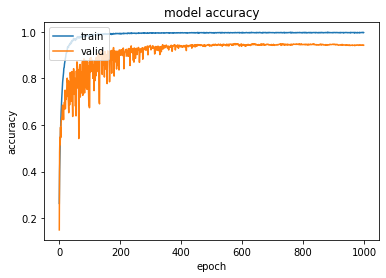

time: 156 ms (started: 2022-11-21 11:57:47 +00:00)


In [23]:
# Summarize history for accuracy.

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

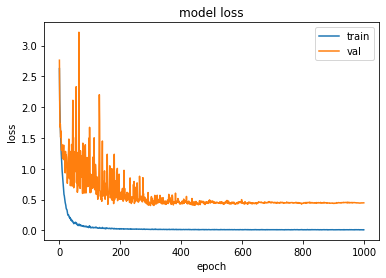

time: 129 ms (started: 2022-11-21 11:57:47 +00:00)


In [24]:
# Summarize history for loss.

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

### Define test pipeline.

In [25]:
class TFRecordPipelineTest(Pipeline):
    def __init__(self, batch_size, num_threads,
                 device = 'cpu', device_id = 0):
        super(TFRecordPipelineTest, self).__init__(batch_size,
                                         num_threads,
                                         device_id)
        self.input = fn.readers.tfrecord(        
             features = {"image_raw": tfrec.FixedLenFeature((), tfrec.string, ""),
                         "label": tfrec.FixedLenFeature([22], tfrec.int64,  22)},
             path = [f_PATH+'tfrecords/22_emo_test.tfrecords'],
             index_path = [f_PATH+'tfrecords/22_emo_test.idx'],
             random_shuffle=False,
             seed = set_seed)
        self.iter = 0
    def define_graph(self):
        inputs = self.input
        images = fn.decoders.image(inputs["image_raw"], device = "mixed", output_type = types.RGB) / 255.
        labels = inputs["label"].gpu()
        return (images, labels)
    def iter_setup(self):
        pass

time: 1.78 ms (started: 2022-11-21 11:57:47 +00:00)


### Check test data accuracy.

In [26]:
# https://docs.nvidia.com/deeplearning/dali/user-guide/docs/plugins/tensorflow_plugin_api.html

if __name__ == "__main__":
    batch_size = 1
    shapes = ((batch_size, 64, 64, 3),
              (batch_size, 22))
    pipe_test = TFRecordPipelineTest(batch_size=batch_size, 
                            num_threads=4, 
                            device='gpu', 
                            device_id=0)

    with tf.device('/gpu:0'):
        ds_test = dali_tf.DALIDataset(
            pipeline=pipe_test,
            batch_size=batch_size,
            output_shapes=shapes,
            output_dtypes=(tf.float32, tf.int64),
            device_id=0)
        print(ds_test)
        loss, acc = clf.evaluate(ds_test, steps=TEST_DATA_SIZE)
        print("Test accuracy:", acc)
        predictions = clf.predict(ds_test.take(5))
        print("A test output from the last layer:", predictions[0])
        print("Index of the maximum value:", np.argmax(predictions[0]))
        print("Label:", LABELS[np.argmax(predictions[0])])

<DALIDataset element_spec=(TensorSpec(shape=(1, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(1, 22), dtype=tf.int64, name=None))>
1980/1980 [==============================] - 23s 11ms/step - loss: 0.3516 - accuracy: 0.9490
Test accuracy: 0.9489899277687073
5/5 [==============================] - 1s 8ms/step
A test output from the last layer: [3.6875055e-16 3.4598990e-19 3.3013504e-16 1.0000000e+00 5.1660226e-19
 3.0299905e-21 3.7300049e-16 2.1845807e-18 1.0874496e-16 1.2006031e-21
 9.0148470e-20 8.7985059e-18 1.4151548e-18 3.7925103e-20 4.1138907e-27
 2.1834916e-16 9.9361549e-16 1.6298177e-15 1.6798418e-15 8.1172057e-16
 2.7681518e-17 6.7702009e-19]
Index of the maximum value: 3
Label: angry
time: 23.9 s (started: 2022-11-21 11:57:47 +00:00)


In [27]:
predictions

array([[3.68750553e-16, 3.45989901e-19, 3.30135035e-16, 1.00000000e+00,
        5.16602262e-19, 3.02999045e-21, 3.73000487e-16, 2.18458069e-18,
        1.08744962e-16, 1.20060308e-21, 9.01484696e-20, 8.79850594e-18,
        1.41515476e-18, 3.79251034e-20, 4.11389075e-27, 2.18349159e-16,
        9.93615493e-16, 1.62981770e-15, 1.67984178e-15, 8.11720567e-16,
        2.76815181e-17, 6.77020086e-19],
       [1.43863199e-16, 5.14225430e-18, 8.45918993e-16, 1.00000000e+00,
        7.25370958e-17, 2.53413598e-20, 6.02957280e-16, 1.04962531e-19,
        1.06869342e-15, 1.44045163e-21, 1.35398661e-18, 1.73395751e-17,
        3.08571787e-17, 1.55577319e-19, 5.12767970e-26, 3.40199285e-15,
        1.60018532e-15, 6.37596385e-15, 3.71478290e-16, 5.58391436e-16,
        6.77891345e-18, 5.46634780e-18],
       [4.55275042e-23, 2.72143385e-24, 3.44060856e-24, 1.78948058e-28,
        1.00000000e+00, 3.10354249e-25, 1.32513051e-27, 7.52657635e-30,
        1.51063141e-25, 4.36917971e-22, 3.24930418e-21

time: 8.29 ms (started: 2022-11-21 11:58:11 +00:00)


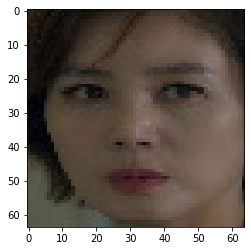

time: 157 ms (started: 2022-11-21 11:58:11 +00:00)


In [28]:
# Display the tested image.

import matplotlib.pyplot as plt

data, = ds_test.take(1)
plt.imshow(data[0][0])

In [29]:
# Check the test data's true label.
data[1]

<tf.Tensor: shape=(1, 22), dtype=int64, numpy=array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])>

time: 5.19 ms (started: 2022-11-21 11:58:11 +00:00)


In [30]:
data

(<tf.Tensor: shape=(1, 64, 64, 3), dtype=float32, numpy=
 array([[[[0.19607843, 0.15686275, 0.10588235],
          [0.18431373, 0.14509805, 0.09411765],
          [0.13725491, 0.10588235, 0.05098039],
          ...,
          [0.07058824, 0.0627451 , 0.05098039],
          [0.10588235, 0.09019608, 0.09019608],
          [0.08235294, 0.06666667, 0.06666667]],
 
         [[0.1764706 , 0.13725491, 0.08627451],
          [0.17254902, 0.13333334, 0.08235294],
          [0.12941177, 0.09803922, 0.04313726],
          ...,
          [0.0627451 , 0.05490196, 0.04313726],
          [0.09411765, 0.07843138, 0.07843138],
          [0.09411765, 0.07843138, 0.07843138]],
 
         [[0.18039216, 0.14901961, 0.09411765],
          [0.15686275, 0.1254902 , 0.07058824],
          [0.1254902 , 0.09019608, 0.04705882],
          ...,
          [0.08627451, 0.07843138, 0.06666667],
          [0.09411765, 0.08627451, 0.08235294],
          [0.07450981, 0.06666667, 0.0627451 ]],
 
         ...,
 
         

time: 6.86 ms (started: 2022-11-21 11:58:11 +00:00)


In [31]:
pred_test = clf.predict(ds_test.take(TEST_DATA_SIZE))

1980/1980 [==============================] - 15s 8ms/step
time: 15.8 s (started: 2022-11-21 11:58:11 +00:00)


In [32]:
true_test = np.concatenate([y for x, y in ds_test.take(TEST_DATA_SIZE)], axis=0)

time: 1.15 s (started: 2022-11-21 11:58:27 +00:00)


In [33]:
true_test.shape

(1980, 22)

time: 5.99 ms (started: 2022-11-21 11:58:28 +00:00)


In [34]:
from sklearn.metrics import confusion_matrix

pred_test_ls = []
true_test_ls = []
for (pred, true) in zip(pred_test, true_test):
    pred_test_ls.append(np.argmax(pred))
    true_test_ls.append(np.argmax(true))

cf_matrix_test = confusion_matrix(true_test_ls, pred_test_ls)
cf_matrix_test

array([[ 27,   0,   0,   1,   1,   0,   0,   0,   0,   0,   1,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   1,   0],
       [  0,  27,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 245,  20,   1,   0,   0,   0,   0,   0,   1,   2,   0,
          0,   1,   0,   1,   0,   0,   0,   0,   0],
       [  1,   0,   4, 745,   0,   0,   1,   0,   0,   0,   3,   0,   1,
          0,   0,   3,   0,   0,   1,   0,   0,   0],
       [  0,   1,   1,   3,  90,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   1,   0,   0,   0,   0],
       [  0,   0,   0,   1,   1,   0,  13,   0,   0,   0,   0,   1,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   4,   3,   0,   0,   0,  83,   0,   0,   0,   0,   0,
          0,   0,   1,   0,   0,   1, 

time: 58.5 ms (started: 2022-11-21 11:58:28 +00:00)


Text(123.0, 0.5, 'True')

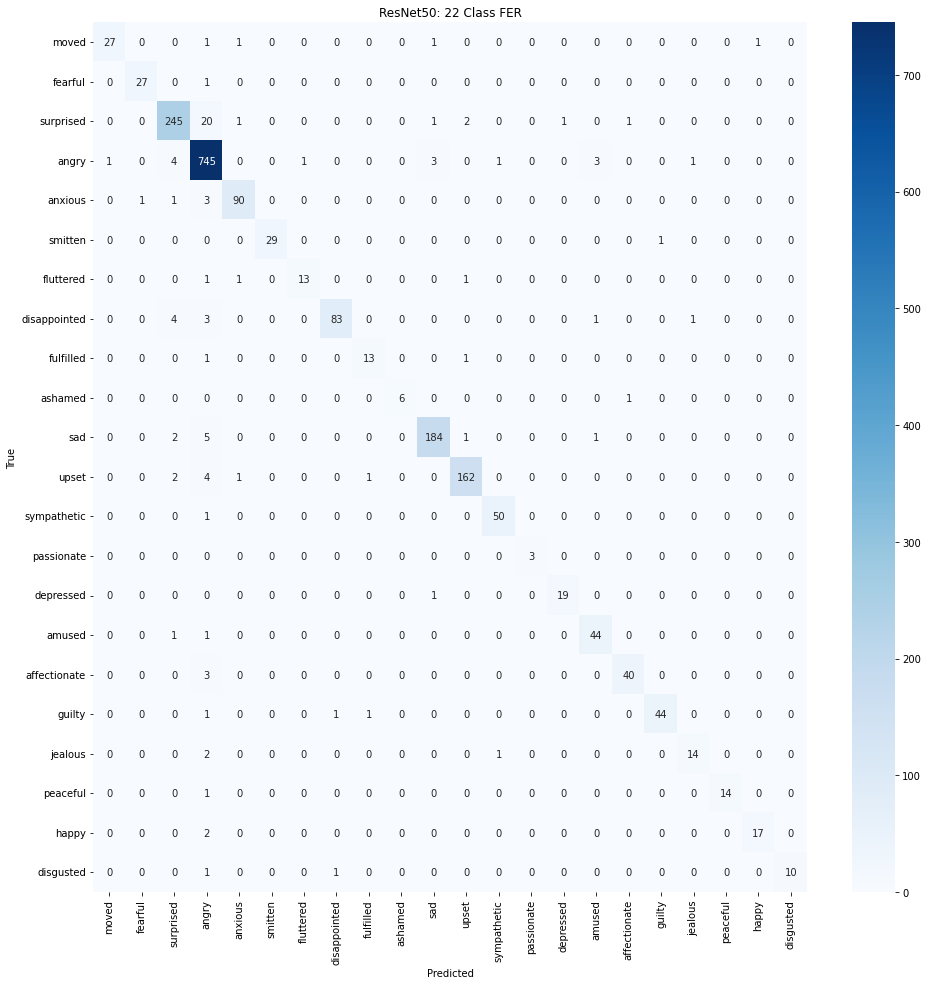

time: 1.76 s (started: 2022-11-21 11:58:28 +00:00)


In [35]:
import seaborn as sns

plt.figure(figsize = (16,16))
sns.heatmap(cf_matrix_test, annot=True, cmap='Blues', xticklabels=LABELS, yticklabels=LABELS, fmt='g')
plt.title('ResNet50: 22 Class FER')
plt.xlabel('Predicted')
plt.ylabel('True')

### Check train data accuracy.

In [36]:
# https://docs.nvidia.com/deeplearning/dali/user-guide/docs/plugins/tensorflow_plugin_api.html

if __name__ == "__main__":
    batch_size = 1
    shapes = ((batch_size, 64, 64, 3),
              (batch_size, 22))
    pipe_train = TFRecordPipelineTrain(batch_size=batch_size, 
                            num_threads=4, 
                            device='gpu', 
                            device_id=0)

    with tf.device('/gpu:0'):
        ds_train = dali_tf.DALIDataset(
            pipeline=pipe_train,
            batch_size=batch_size,
            output_shapes=shapes,
            output_dtypes=(tf.float32, tf.int64),
            device_id=0)
        loss, acc = clf.evaluate(ds_train, steps=TRAIN_DATA_SIZE)
        print("Train accuracy:", acc)
        #predictions = clf.predict(ds_train.take(1))
        #print("A test output from the last layer:", predictions[0])
        #print("Index of the maximum value:", np.argmax(predictions[0]))
        #print("Label:", LABELS[np.argmax(predictions[0])])

15840/15840 [==============================] - 158s 10ms/step - loss: 2.1975e-09 - accuracy: 1.0000
Train accuracy: 1.0
time: 2min 37s (started: 2022-11-21 11:58:30 +00:00)


In [37]:
pred_train = clf.predict(ds_train.take(TRAIN_DATA_SIZE))

15840/15840 [==============================] - 125s 8ms/step
time: 2min 7s (started: 2022-11-21 12:01:08 +00:00)


In [38]:
true_train = np.concatenate([y for x, y in ds_train.take(TRAIN_DATA_SIZE)], axis=0)

time: 8.32 s (started: 2022-11-21 12:03:15 +00:00)


In [39]:
true_train.shape

(15840, 22)

time: 6.72 ms (started: 2022-11-21 12:03:23 +00:00)


In [40]:
pred_train_ls = []
true_train_ls = []
for (pred, true) in zip(pred_train, true_train):
    pred_train_ls.append(np.argmax(pred))
    true_train_ls.append(np.argmax(true))

cf_matrix_train = confusion_matrix(true_train_ls, pred_train_ls)
cf_matrix_train

array([[ 250,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,  224,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0, 2172,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0, 6068,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,  761,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,  240,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,  128,    0,    0,    0,    0,
           0,    0,    0,    0, 

time: 64.6 ms (started: 2022-11-21 12:03:23 +00:00)


Text(123.0, 0.5, 'True')

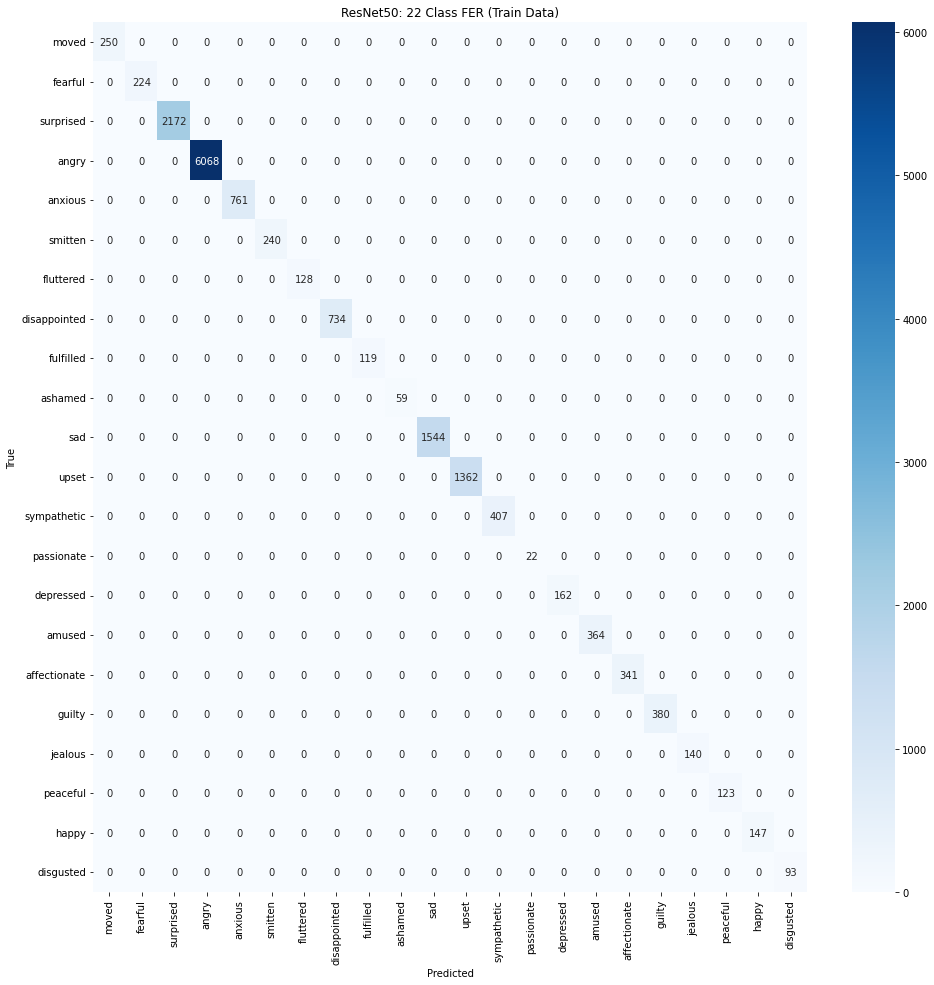

time: 1.6 s (started: 2022-11-21 12:03:24 +00:00)


In [41]:
plt.figure(figsize = (16,16))
sns.heatmap(cf_matrix_train, annot=True, cmap='Blues', xticklabels=LABELS, yticklabels=LABELS, fmt='g')
plt.title('ResNet50: 22 Class FER (Train Data)')
plt.xlabel('Predicted')
plt.ylabel('True')

time: 1.64 s (started: 2022-10-26 15:28:29 +00:00)
